This project's goal is to analyze my listening habits on Spotify. Specifically we will be focusing on where the artists that I listen to where born and how my listening habits change through time based on when the song was released. We will need to assemble our own data based on my personal spotify account. Then we used Folium and a seasonal decomposition package to analyze the data. 
The data was assembled by using the Spotify API to get songs and artists that I listen too. In order to get there birth place and geographical data of where the artist was born I used Openai API. I passed all the songs and artists to the openai API and prompted it to get a structured response back that was then added to my data frame.  After using Folium it was clear that some of the data I recieved from the OpenAI API was either completly wrong or the response format was incorrect. In order to correct this I manually corrected it usig Google Maps. After cleaning we had a map that shows where each artist that you listen too is from! Now lets take you through my notebook so you can see how everything was done step by step.

# Assemble The Data

This is considered the proper way to handle api keys securly. Since we are using a couple api's I decided to try it out. We have create a .env file within our folder and in the file we assign variable. These are commonly refered to as enviorment variables and we can use them in any file inside of our project folder.

In [118]:
from dotenv import load_dotenv
import os
load_dotenv()
api_client_id = os.getenv("SPOTIPY_CLIENT_ID")
api_secret = os.getenv("SPOTIPY_CLIENT_SECRET")
api_redirect_uri = os.getenv("SPOTIPY_REDIRECT_URI")
gpt_secret = os.getenv("gpt_secret")

## Spotify Data

Next we gather data from the spotify api using a package called Spotipy. This package made the aunthentication project much easeir to deal with. https://spotipy.readthedocs.io/en/2.22.1/

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

#We first need to authenticate ourselves with the spotify api through the 'app' using the spotipy library
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=api_client_id,
                                               client_secret=api_secret,
                                               redirect_uri=api_redirect_uri,
                                               scope='user-library-read'))

# getting all the 'tracks' data from the api
results = sp.current_user_saved_tracks(limit=50)
liked_songs = {}

# ^ that 'results' is the return of the call from the api and it looks like ass so lets clean it and put it in dictionary
for idx, item in enumerate(results['items']):
    track = item['track']
    song_name = track['name']
    artist_names = [artist['name'] for artist in track['artists']]
    liked_songs[song_name] = artist_names

# if you look up at results you see the limit = 50, this is the limit set by the spotify api
# in order to get around this 
while results['next']:
    results = sp.next(results)
    for idx, item in enumerate(results['items']):
        track = item['track']
        song_name = track['name']
        artist_names = [artist['name'] for artist in track['artists']]
        liked_songs[song_name] = artist_names

# Now the liked songs are stored in the liked_songs dictionary
print("Total number of liked songs:", len(liked_songs))
print(liked_songs)

Total number of liked songs: 2106
{'Freeze Tag (feat. Phoelix)': ['Terrace Martin', 'Robert Glasper', '9th Wonder', 'Kamasi Washington', 'Dinner Party', 'Phoelix'], 'Church': ['BJ The Chicago Kid', 'Chance the Rapper', 'Buddy'], 'Louie Bag (feat. Smino)': ['Yebba', 'Smino'], 'Love To Last': ['Hajaj'], 'Liquor Store In The Sky (feat. Freddie Gibbs)': ['BJ The Chicago Kid', 'Freddie Gibbs'], "The Better Benediction (pt.2) (feat. Lisa Knowles-Smith, Le'Andria Johnson, KeKe Wyatt, Kierra Sheard & Tasha Cobbs Leonard)": ['PJ Morton', 'Lisa Knowles-Smith', "Le'Andria Johnson", 'KeKe Wyatt', 'Kierra Sheard', 'Tasha Cobbs Leonard'], 'Bring it on Home to Me (feat. Charlie Bereal)': ['BJ The Chicago Kid', 'PJ Morton', 'Kenyon Dixon', 'Charlie Bereal'], 'Not Like Us': ['Kendrick Lamar'], 'meet the grahams': ['Kendrick Lamar'], "What's on your mind?": ['FiJA'], 'Distance': ['Emily King'], 'Tennessee Whiskey - Live': ['T-Pain'], 'KLINK': ['Smino'], 'Outskirts of Heaven': ['Matt Schuster'], 'Kate Mc

Lets put our Data from spotify into a pandas Data Frame for an easier time messing with the data.

In [50]:
import pandas as pd

In [52]:
transpose_dic = {'Song' : list(liked_songs.keys()),'Artist': list(liked_songs.values())}
df = pd.DataFrame(transpose_dic)
df

Song  \
0                        Freeze Tag (feat. Phoelix)   
1                                            Church   
2                           Louie Bag (feat. Smino)   
3                                      Love To Last   
4     Liquor Store In The Sky (feat. Freddie Gibbs)   
...                                             ...   
2101                      The Incredible True Story   
2102                                  1984 - Part 4   
2103                                  1984 - Part 3   
2104                                  1984 - Part 2   
2105                                  1984 - Part 1   

                                                 Artist  
0     [Terrace Martin, Robert Glasper, 9th Wonder, K...  
1        [BJ The Chicago Kid, Chance the Rapper, Buddy]  
2                                        [Yebba, Smino]  
3                                               [Hajaj]  
4                   [BJ The Chicago Kid, Freddie Gibbs]  
...                                                 ...  
2101                                            [Logic]  
2102                       [David Niven, George Orwell]  
2103                       [David Niven, George Orwell]  
2104                       [David Niven, George Orwell]  
2105                       [David Niven, George Orwell]  

[2106 rows x 2 columns]

In [55]:
df['State'] = 'N/A'
df['Lat'] = 0
df['Long'] = 0
df['Song_Release_Year'] = 'N/A'
df['Song_Release_Month'] = 'N/A'
df

Song  \
0                        Freeze Tag (feat. Phoelix)   
1                                            Church   
2                           Louie Bag (feat. Smino)   
3                                      Love To Last   
4     Liquor Store In The Sky (feat. Freddie Gibbs)   
...                                             ...   
2101                      The Incredible True Story   
2102                                  1984 - Part 4   
2103                                  1984 - Part 3   
2104                                  1984 - Part 2   
2105                                  1984 - Part 1   

                                                 Artist State  Lat  Long  
0     [Terrace Martin, Robert Glasper, 9th Wonder, K...   N/A    0     0  
1        [BJ The Chicago Kid, Chance the Rapper, Buddy]   N/A    0     0  
2                                        [Yebba, Smino]   N/A    0     0  
3                                               [Hajaj]   N/A    0     0  
4                   [BJ The Chicago Kid, Freddie Gibbs]   N/A    0     0  
...                                                 ...   ...  ...   ...  
2101                                            [Logic]   N/A    0     0  
2102                       [David Niven, George Orwell]   N/A    0     0  
2103                       [David Niven, George Orwell]   N/A    0     0  
2104                       [David Niven, George Orwell]   N/A    0     0  
2105                       [David Niven, George Orwell]   N/A    0     0  

[2106 rows x 5 columns]

## Openai Data

To gather the rest of my data (Where the artist was born, Latitude and Longitude of birthplace, and the Month and Year the song was released) I wanted to try out the Openai API. https://github.com/openai/openai-python/blob/main/README.md

In [121]:
load_dotenv()

True

In [123]:
df_copy = df.copy()

In [ ]:
client = OpenAI()
for index, row in df.iterrows():
    song = row['Song']
    artist_list = row['Artist']
    artist_name = artist_list[0]
    response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "system", "content": '''You are a helpful assistant. You will be given an artist name and song. You need
      to tell me what state or country the artist is from and what month and year the song was released. Also tell me 
      the latitude and longitude cordinates of the state or country, ommit N-S E-W designators and instead have the value neagtive for S and W.
       Your response should only include country if the artist was born outside of the United States. Your response 
      will only be formated like this: 'country/state' ,'latitude value', 'longitude value','month' ,'year' 
      There should never be USA, United States, or United States of America in your response.'''},
      {"role": "user", "content": song+ "," + artist_name}
      
    ]
    )
    # print(artist_name)
    og = response.choices[0].message.content
    # print(type(og), og)
    split_strings = []
    split_strings = [s.strip() for s in og.split(',')]
    # print(type(split_strings), split_st
    try:
        df.at[index,'State'] = split_strings[0]
        df.at[index,'Lat'] = float(split_strings[1])
        df.at[index,'Long']= float(split_strings[2])
        df.at[index,'Song_Release_Month'] = split_strings[3]
        df.at[index,'Song_Release_Year'] = split_strings[4]
    except(ValueError, IndexError):
        continue

df

In [ ]:
df.to_csv('my_liked.csv', index=False) 

In [125]:
df = pd.read_csv('my_liked.csv')
df

Song  \
0                        Freeze Tag (feat. Phoelix)   
1                                            Church   
2                           Louie Bag (feat. Smino)   
3                                      Love To Last   
4     Liquor Store In The Sky (feat. Freddie Gibbs)   
...                                             ...   
2101                      The Incredible True Story   
2102                                  1984 - Part 4   
2103                                  1984 - Part 3   
2104                                  1984 - Part 2   
2105                                  1984 - Part 1   

                                                 Artist           State  \
0     ['Terrace Martin', 'Robert Glasper', '9th Wond...      California   
1     ['BJ The Chicago Kid', 'Chance the Rapper', 'B...        Illinois   
2                                    ['Yebba', 'Smino']         Nigeria   
3                                             ['Hajaj']         Nigeria   
4               ['BJ The Chicago Kid', 'Freddie Gibbs']        Illinois   
...                                                 ...             ...   
2101                                          ['Logic']        Maryland   
2102                   ['David Niven', 'George Orwell']  United Kingdom   
2103                   ['David Niven', 'George Orwell']  United Kingdom   
2104                   ['David Niven', 'George Orwell']  United Kingdom   
2105                   ['David Niven', 'George Orwell']  United Kingdom   

          Lat      Long Song_Release_Year Song_Release_Month  
0     34.0000 -118.0000              2019                May  
1     41.0000   89.0000              2019             August  
2      9.0000    8.0000              2021             August  
3     10.0000    8.0000              2021          September  
4     41.0000   87.0000              2016              April  
...       ...       ...               ...                ...  
2101  39.0000  -77.0000              2015           November  
2102  51.5074   -0.1278              1963               June  
2103  51.5074   -0.1278              1981           December  
2104  55.0000   -4.0000            "1984"          "Unknown"  
2105  51.5074   -0.1278              1984            January  

[2106 rows x 7 columns]

In [139]:
import ast

In [140]:
df['Artist'] = df['Artist'].apply(ast.literal_eval)
print(df['Artist'][0][0])

Terrace Martin


In [127]:
import folium 

In [141]:
my_map = folium.Map(location = [df.Lat.mean(), df.Long.mean()])
tooltip_str = "Click Here For More Info"

for index, location_info in df.iterrows():
    folium.Marker([location_info["Lat"],
                   location_info["Long"]],
                   popup=location_info["Artist"][0],
                   icon=folium.Icon(icon="music", color='red'),
                   tooltip=tooltip_str
                   ).add_to(my_map)

In [142]:
my_map

^So as we can see on the map gpt made a few errors while gathering the data. Obviosly we can't blindly trust but this could have happened any number of ways. When revisiting this project I intend to mess with the prompts that it was fed to see if I can get more accurate data. Either way we gotta clean this up a bit.  

## Clean Up!

In [144]:
df['not_feature_artist'] = df['Artist'].apply(lambda x: x[0])
unique_df = pd.DataFrame({'Artist': df['not_feature_artist'].unique()})
unique_df


Artist
0        Terrace Martin
1    BJ The Chicago Kid
2                 Yebba
3                 Hajaj
4             PJ Morton
..                  ...
734        Jimi Hendrix
735    The Chainsmokers
736     Louis Armstrong
737         Miles Davis
738         David Niven

[739 rows x 1 columns]

In [149]:
from scipy.stats import mode
import numpy as np

In [151]:
df.dtypes

Song                   object
Artist                 object
State                  object
Lat                   float64
Long                  float64
Song_Release_Year      object
Song_Release_Month     object
not_feature_artist     object
dtype: object

Instead of manually going through all of the rows and fixing the data one by one lets first standerdize our map data by taking the mode of the State, Latitude and Longitude columns. This relies on the fact the gpt got the correct data MOST of the time. We will see later that wasnt entirely true.

In [156]:
mode_states = []
mode_lats = []
mode_longs = []
for artist in unique_df['Artist']:

    artist_data = df[df['not_feature_artist'] == artist]
    

    unique_states, state_counts = np.unique(artist_data['State'], return_counts=True)
    mode_state = unique_states[np.argmax(state_counts)]
    

    unique_lats, lat_counts = np.unique(artist_data['Lat'], return_counts=True)
    mode_lat = unique_lats[np.argmax(lat_counts)]
    
 
    unique_longs, long_counts = np.unique(artist_data['Long'], return_counts=True)
    mode_long = unique_longs[np.argmax(long_counts)]
    

    mode_states.append(mode_state)
    mode_lats.append(mode_lat)
    mode_longs.append(mode_long)
    
unique_df['State'] = mode_states
unique_df['Lat'] = mode_lats
unique_df['Long'] = mode_longs


In [158]:
unique_df.head(8)

Artist       State   Lat   Long
0      Terrace Martin  California  34.0 -118.0
1  BJ The Chicago Kid    Illinois  41.0   87.0
2               Yebba    Arkansas   9.0  -92.0
3               Hajaj     Nigeria  10.0    8.0
4           PJ Morton   Louisiana  30.0  -91.0
5      Kendrick Lamar  California  34.0 -118.0
6                FiJA   Australia -25.0  133.0
7          Emily King    New York  40.0  -74.0

In [161]:
my_map_v2 = folium.Map(location = [df.Lat.mean(), df.Long.mean()])
tooltip_str = "Click Here For More Info"

for index, location_info in unique_df.iterrows():
    folium.Marker([location_info["Lat"],
                   location_info["Long"]],
                   popup=location_info["Artist"],
                   icon=folium.Icon(icon="music", color='red'),
                   tooltip=tooltip_str
                   ).add_to(my_map_v2)

In [162]:
my_map_v2

Okay Beyonce is no longer chinese so.. we are getting somewhere

In [165]:
test_df = unique_df.copy()
grouped = test_df.groupby('State')['Artist'].apply(list).reset_index()

State                                             Artist
0                "Virginia"                                           [Masego]
1                'Illinois'                                           [Twista]
2                 'Jamaica'                                            [Shyne]
3            'Pennsylvania'                                   [Gerry Mulligan]
4          'United Kingdom'                                   [Jonathan Pryce]
..                      ...                                                ...
96               Washington  [Foo Fighters, Allen Stone, Heart, The Head An...
97            Washington DC                                     [Citizen Cope]
98            West Virginia                                     [Bill Withers]
99                Wisconsin                [Mike Dimes, Bon Iver, Boom Forest]
100  country: United States                                      [Barry White]

[101 rows x 2 columns]

In [167]:
grouped

State                                             Artist
0                  Virginia                                           [Masego]
1                  Illinois                                           [Twista]
2                   Jamaica                                            [Shyne]
3              Pennsylvania                                   [Gerry Mulligan]
4            United Kingdom                                   [Jonathan Pryce]
..                      ...                                                ...
96               Washington  [Foo Fighters, Allen Stone, Heart, The Head An...
97            Washington DC                                     [Citizen Cope]
98            West Virginia                                     [Bill Withers]
99                Wisconsin                [Mike Dimes, Bon Iver, Boom Forest]
100  country: United States                                      [Barry White]

[101 rows x 2 columns]

I decided to instead of having a point for each song why dont I have one point for every state/country in the data set and then list the Artisit by birthplace.

In [191]:
test_df = unique_df.copy()
test_df['State'] = test_df['State'].str.replace('"', '').str.replace("'", "")
# unique_df = pd.DataFrame({'Artist': df['not_feature_artist'].unique()})
# unique_df
test_df

Artist                              State      Lat      Long
0        Terrace Martin                         California  34.0000 -118.0000
1    BJ The Chicago Kid                           Illinois  41.0000   87.0000
2                 Yebba                           Arkansas   9.0000  -92.0000
3                 Hajaj                            Nigeria  10.0000    8.0000
4             PJ Morton                          Louisiana  30.0000  -91.0000
..                  ...                                ...      ...       ...
734        Jimi Hendrix                         Washington  47.0000 -122.0000
735    The Chainsmokers                                USA  38.0000  -97.0000
736     Louis Armstrong  Louis Armstrong is from Louisiana   0.0000    0.0000
737         Miles Davis                           New York  40.0000  -74.0000
738         David Niven                     United Kingdom  51.5074   -0.1278

[739 rows x 4 columns]

In [257]:
def calculate_mode(group):
    unique_lats, lat_counts = np.unique(group['Lat'], return_counts=True)
    if len(unique_lats) == 1:
        mode_lat = unique_lats[0]
    else:
        mode_lat = unique_lats[np.argmax(lat_counts)]
    
    unique_longs, long_counts = np.unique(group['Long'], return_counts=True)
    if len(unique_longs) == 1:
        mode_long = unique_longs[0]
    else:
        mode_long = unique_longs[np.argmax(long_counts)]
    
    artists = group['Artist'].tolist()
    return pd.Series({'Lat': float(mode_lat), 'Long': float(mode_long), 'Artists': artists})


result_df = test_df.groupby('State').apply(calculate_mode).reset_index()
result_df

/var/folders/g2/083sznd95s3bg6b4np16l62h0000gn/T/ipykernel_8564/1383076275.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = test_df.groupby('State').apply(calculate_mode).reset_index()


State   Lat   Long  \
0                  Alabama  32.0   86.0   
1                Argentina -34.0  -64.0   
2                  Arizona  33.0 -112.0   
3                 Arkansas  35.0  -92.0   
4                Australia -25.0  133.0   
..                     ...   ...    ...   
89              Washington  47.0 -122.0   
90           Washington DC  38.0  -77.0   
91           West Virginia  38.0  -80.0   
92               Wisconsin  44.0  -90.0   
93  country: United States  33.0 -118.0   

                                              Artists  
0   [Rich Boy, Alabama Shakes, Commodores, Muscadi...  
1                                            [Trueno]  
2                    [Jimmy Eat World, Jordin Sparks]  
3                 [Yebba, Glen Campbell, Johnny Cash]  
4   [FiJA, Flume, Gotye, The Paper Kites, The Tesk...  
..                                                ...  
89  [Foo Fighters, Allen Stone, Heart, The Head An...  
90                                     [Citizen Cope]  
91                                     [Bill Withers]  
92                [Mike Dimes, Bon Iver, Boom Forest]  
93                                      [Barry White]  

[94 rows x 4 columns]

# Analysis

In [204]:
result_df.columns
# print(', '.join(result_df["Artist"][0]))

Index(['State', 'Lat', 'Long', 'Artists'], dtype='object')

Map looked a lot better but there was still some data points that were out of place. So I manually went through and moved some of the points around. 

In [297]:
result_df = result_df[result_df['State'] != 'United States']
result_df = result_df[result_df['State'] != 'Im sorry']
result_df = result_df[result_df['State'] != 'US']
result_df = result_df[result_df['State'] != 'USA']
result_df = result_df[result_df['State'] != 'Los Angeles']
result_df = result_df[result_df['State'] != 'Louis Armstrong is from Louisiana']
result_df = result_df[result_df['State'] != 'UK']
result_df = result_df[result_df['State'] != 'London']
result_df = result_df[result_df['State'] != 'country: United States']
result_df.loc[result_df['State'] == 'Oregon', 'Lat'] = 43.917
result_df.loc[result_df['State'] == 'Oregon', 'Long'] = -120.485
result_df.loc[result_df['State'] == 'Nevada', 'Lat'] = 39.637
result_df.loc[result_df['State'] == 'Nevada', 'Long'] = -116.8
result_df.loc[result_df['State'] == 'Minnesota', 'Lat'] = 45.73
result_df.loc[result_df['State'] == 'Minnesota', 'Long'] = -94.62
result_df.loc[result_df['State'] == 'Illinois', 'Lat'] = 39.78
result_df.loc[result_df['State'] == 'Illinois', 'Long'] = -89.16
result_df.loc[result_df['State'] == 'West Virginia', 'Lat'] = 38.75
result_df.loc[result_df['State'] == 'West Virginia', 'Long'] = -80.89
result_df.loc[result_df['State'] == 'South Carolina', 'Lat'] = 33.52
result_df.loc[result_df['State'] == 'South Carolina', 'Long'] = -80.56
result_df.loc[result_df['State'] == 'Maryland', 'Lat'] = 39.4
result_df.loc[result_df['State'] == 'Maryland', 'Long'] = -76.92
result_df.loc[result_df['State'] == 'Washington DC', 'Lat'] = 38.88
result_df.loc[result_df['State'] == 'Washington DC', 'Long'] = -76.96
result_df.loc[result_df['State'] == 'New York', 'Lat'] = 40.82
result_df.loc[result_df['State'] == 'New York', 'Long'] = -73.94
result_df.loc[result_df['State'] == 'New Jersey', 'Lat'] = 40.09
result_df.loc[result_df['State'] == 'New Jersey', 'Long'] = -74.43
result_df.loc[result_df['State'] == 'Connecticut', 'Lat'] = 41.69
result_df.loc[result_df['State'] == 'Connecticut', 'Long'] = -72.66
result_df.loc[result_df['State'] == 'Vermont', 'Lat'] = 43.97
result_df.loc[result_df['State'] == 'Vermont', 'Long'] = -72.79
result_df.loc[result_df['State'] == 'New Hampshire', 'Lat'] = 43.76
result_df.loc[result_df['State'] == 'New Hampshire', 'Long'] = -71.53
result_df.loc[result_df['State'] == 'Canada', 'Lat'] = 53.41
result_df.loc[result_df['State'] == 'Canada', 'Long'] = -102.12
result_df.loc[result_df['State'] == 'Brazil', 'Lat'] = -11.49
result_df.loc[result_df['State'] == 'Brazil', 'Long'] = -50.94
test_df.loc[test_df['State'] == 'Memphis', 'State'] = 'Tennessee'
result_df.loc[result_df['State'] == 'Portugal', 'Lat'] = 40.38
result_df.loc[result_df['State'] == 'Portugal', 'Long'] = -8.02
result_df.loc[result_df['State'] == 'Netherlands', 'Lat'] = 52.25
result_df.loc[result_df['State'] == 'Netherlands', 'Long'] = 5.83
result_df.loc[result_df['State'] == 'Northern Ireland', 'Lat'] = 54.91
result_df.loc[result_df['State'] == 'Northern Ireland', 'Long'] = -6.75
result_df.loc[result_df['State'] == 'United Kingdom', 'Lat'] = 53.01
result_df.loc[result_df['State'] == 'United Kingdom', 'Long'] = -1.07
result_df.loc[result_df['State'] == 'Spain', 'Lat'] = 40.38
result_df.loc[result_df['State'] == 'Spain', 'Long'] = -2.72
result_df.loc[result_df['State'] == 'Iceland', 'Lat'] = 64.56
result_df.loc[result_df['State'] == 'Iceland', 'Long'] = -17.96
result_df.loc[result_df['State'] == 'Senegal', 'Lat'] = 14.42
result_df.loc[result_df['State'] == 'Senegal', 'Long'] = -14.65
result_df.loc[result_df['State'] == 'Norway', 'Lat'] = 60.9
result_df.loc[result_df['State'] == 'Norway', 'Long'] = 9.22
result_df.loc[result_df['State'] == 'Barbados', 'Lat'] = 13.22
result_df.loc[result_df['State'] == 'Barbados', 'Long'] = -59.57
result_df.loc[result_df['State'] == 'Puerto Rico', 'Lat'] = 18.306
result_df.loc[result_df['State'] == 'Puerto Rico', 'Long'] = -66.63
result_df.loc[result_df['State'] == 'Florida', 'Lat'] = 27.57
result_df.loc[result_df['State'] == 'Florida', 'Long'] = -81.32
result_df.loc[result_df['State'] == 'Alabama', 'Lat'] = 32.28
result_df.loc[result_df['State'] == 'Alabama', 'Long'] = -86.47
result_df.loc[result_df['State'] == 'North Dakota', 'Lat'] = 46.97
result_df.loc[result_df['State'] == 'North Dakota', 'Long'] = -99.57

In [407]:
my_map_v3 = folium.Map(location = [result_df.Lat.mean(), result_df.Long.mean()],zoom_start= 2)
tooltip_str = "Click Here For More Info"

for index, location_info in result_df.iterrows():
    state_map = location_info['State']
    if len(location_info['Artists']) == 1:
        artists_str = location_info["Artists"][0]  # Use the single element directly
    else:
        artists_str = ', '.join(location_info['Artists'])
        
    popup_str = state_map + ': ' +artists_str
    folium.Marker([location_info["Lat"],
                   location_info["Long"]],
                   popup=popup_str,
                   icon=folium.Icon(icon="music", color='red'),
                   tooltip=tooltip_str
                   ).add_to(my_map_v3)

In [408]:
my_map_v3


In [410]:
my_map_v3.save('Liked_songs_map.html')

## Time Series Analysis

I decided to see how much my Liked songs playsit grew based on the time the song was released. Basically old songs vs. new songs.

In [324]:
time_series_df = df.copy()
time_series_df

Song  \
0                        Freeze Tag (feat. Phoelix)   
1                                            Church   
2                           Louie Bag (feat. Smino)   
3                                      Love To Last   
4     Liquor Store In The Sky (feat. Freddie Gibbs)   
...                                             ...   
2101                      The Incredible True Story   
2102                                  1984 - Part 4   
2103                                  1984 - Part 3   
2104                                  1984 - Part 2   
2105                                  1984 - Part 1   

                                                 Artist           State  \
0     [Terrace Martin, Robert Glasper, 9th Wonder, K...      California   
1        [BJ The Chicago Kid, Chance the Rapper, Buddy]        Illinois   
2                                        [Yebba, Smino]         Nigeria   
3                                               [Hajaj]         Nigeria   
4                   [BJ The Chicago Kid, Freddie Gibbs]        Illinois   
...                                                 ...             ...   
2101                                            [Logic]        Maryland   
2102                       [David Niven, George Orwell]  United Kingdom   
2103                       [David Niven, George Orwell]  United Kingdom   
2104                       [David Niven, George Orwell]  United Kingdom   
2105                       [David Niven, George Orwell]  United Kingdom   

          Lat      Long Song_Release_Year Song_Release_Month  \
0     34.0000 -118.0000              2019                 05   
1     41.0000   89.0000              2019                 08   
2      9.0000    8.0000              2021                 08   
3     10.0000    8.0000              2021                 09   
4     41.0000   87.0000              2016                 04   
...       ...       ...               ...                ...   
2101  39.0000  -77.0000              2015                 11   
2102  51.5074   -0.1278              1963                 06   
2103  51.5074   -0.1278              1981                 12   
2104  55.0000   -4.0000            "1984"                NaN   
2105  51.5074   -0.1278              1984                 01   

      not_feature_artist  
0         Terrace Martin  
1     BJ The Chicago Kid  
2                  Yebba  
3                  Hajaj  
4     BJ The Chicago Kid  
...                  ...  
2101               Logic  
2102         David Niven  
2103         David Niven  
2104         David Niven  
2105         David Niven  

[2106 rows x 8 columns]

In [334]:
time_series_df = time_series_df.dropna(subset=['Song_Release_Year', 'Song_Release_Month'])

In [337]:
time_series_df['Release_Date'] = time_series_df['Song_Release_Month'].astype(str) + '-' + time_series_df['Song_Release_Year'].astype(str)
time_series_df.head(125)

Song  \
0                       Freeze Tag (feat. Phoelix)   
1                                           Church   
2                          Louie Bag (feat. Smino)   
3                                     Love To Last   
4    Liquor Store In The Sky (feat. Freddie Gibbs)   
..                                             ...   
127                                         EXIT 9   
128              Ballads (with Conway The Machine)   
129           Scatter Brain (feat. Ludacris & JID)   
130                                       Too Much   
131                                     Many Times   

                                                Artist       State   Lat  \
0    [Terrace Martin, Robert Glasper, 9th Wonder, K...  California  34.0   
1       [BJ The Chicago Kid, Chance the Rapper, Buddy]    Illinois  41.0   
2                                       [Yebba, Smino]     Nigeria   9.0   
3                                              [Hajaj]     Nigeria  10.0   
4                  [BJ The Chicago Kid, Freddie Gibbs]    Illinois  41.0   
..                                                 ...         ...   ...   
127                               [Killer Mike, Blxst]     Georgia  33.0   
128                          [JID, Conway the Machine]     Georgia  33.0   
129                [Conway the Machine, Ludacris, JID]    New York  42.0   
130                                    [Drake, Sampha]     Ontario  43.0   
131                                            [Dijon]      France  48.0   

      Long Song_Release_Year Song_Release_Month  not_feature_artist  \
0   -118.0              2019                 05      Terrace Martin   
1     89.0              2019                 08  BJ The Chicago Kid   
2      8.0              2021                 08               Yebba   
3      8.0              2021                 09               Hajaj   
4     87.0              2016                 04  BJ The Chicago Kid   
..     ...               ...                ...                 ...   
127  -83.0              2003                 03         Killer Mike   
128   84.0              2021                 02                 JID   
129  -74.0              2021                 10  Conway the Machine   
130  -79.0              2014                 07               Drake   
131    2.0              2019                 11               Dijon   

    Release_Date  
0        05-2019  
1        08-2019  
2        08-2021  
3        09-2021  
4        04-2016  
..           ...  
127      03-2003  
128      02-2021  
129      10-2021  
130      07-2014  
131      11-2019  

[125 rows x 9 columns]

In [367]:
time_series_df['Release_Date'] = pd.to_datetime(time_series_df['Release_Date'], format='mixed')
time_series_df

Song  \
0                            Freeze Tag (feat. Phoelix)   
1                                                Church   
2                               Louie Bag (feat. Smino)   
3                                          Love To Last   
4         Liquor Store In The Sky (feat. Freddie Gibbs)   
...                                                 ...   
2100  So What (feat. John Coltrane, Cannonball Adder...   
2101                          The Incredible True Story   
2102                                      1984 - Part 4   
2103                                      1984 - Part 3   
2105                                      1984 - Part 1   

                                                 Artist           State  \
0     [Terrace Martin, Robert Glasper, 9th Wonder, K...      California   
1        [BJ The Chicago Kid, Chance the Rapper, Buddy]        Illinois   
2                                        [Yebba, Smino]         Nigeria   
3                                               [Hajaj]         Nigeria   
4                   [BJ The Chicago Kid, Freddie Gibbs]        Illinois   
...                                                 ...             ...   
2100  [Miles Davis, John Coltrane, Cannonball Adderl...        New York   
2101                                            [Logic]        Maryland   
2102                       [David Niven, George Orwell]  United Kingdom   
2103                       [David Niven, George Orwell]  United Kingdom   
2105                       [David Niven, George Orwell]  United Kingdom   

          Lat      Long Song_Release_Year Song_Release_Month  \
0     34.0000 -118.0000              2019                 05   
1     41.0000   89.0000              2019                 08   
2      9.0000    8.0000              2021                 08   
3     10.0000    8.0000              2021                 09   
4     41.0000   87.0000              2016                 04   
...       ...       ...               ...                ...   
2100  40.0000  -74.0000              1959                 03   
2101  39.0000  -77.0000              2015                 11   
2102  51.5074   -0.1278              1963                 06   
2103  51.5074   -0.1278              1981                 12   
2105  51.5074   -0.1278              1984                 01   

      not_feature_artist Release_Date  
0         Terrace Martin   2019-05-01  
1     BJ The Chicago Kid   2019-08-01  
2                  Yebba   2021-08-01  
3                  Hajaj   2021-09-01  
4     BJ The Chicago Kid   2016-04-01  
...                  ...          ...  
2100         Miles Davis   1959-03-01  
2101               Logic   2015-11-01  
2102         David Niven   1963-06-01  
2103         David Niven   1981-12-01  
2105         David Niven   1984-01-01  

[1912 rows x 9 columns]

In [368]:
#extra copy
copy_time_series_df = time_series_df.copy()

In [370]:
date_index_df = time_series_df.set_index('Release_Date')
date_index_df

Song  \
Release_Date                                                      
2019-05-01                           Freeze Tag (feat. Phoelix)   
2019-08-01                                               Church   
2021-08-01                              Louie Bag (feat. Smino)   
2021-09-01                                         Love To Last   
2016-04-01        Liquor Store In The Sky (feat. Freddie Gibbs)   
...                                                         ...   
1959-03-01    So What (feat. John Coltrane, Cannonball Adder...   
2015-11-01                            The Incredible True Story   
1963-06-01                                        1984 - Part 4   
1981-12-01                                        1984 - Part 3   
1984-01-01                                        1984 - Part 1   

                                                         Artist  \
Release_Date                                                      
2019-05-01    [Terrace Martin, Robert Glasper, 9th Wonder, K...   
2019-08-01       [BJ The Chicago Kid, Chance the Rapper, Buddy]   
2021-08-01                                       [Yebba, Smino]   
2021-09-01                                              [Hajaj]   
2016-04-01                  [BJ The Chicago Kid, Freddie Gibbs]   
...                                                         ...   
1959-03-01    [Miles Davis, John Coltrane, Cannonball Adderl...   
2015-11-01                                              [Logic]   
1963-06-01                         [David Niven, George Orwell]   
1981-12-01                         [David Niven, George Orwell]   
1984-01-01                         [David Niven, George Orwell]   

                       State      Lat      Long Song_Release_Year  \
Release_Date                                                        
2019-05-01        California  34.0000 -118.0000              2019   
2019-08-01          Illinois  41.0000   89.0000              2019   
2021-08-01           Nigeria   9.0000    8.0000              2021   
2021-09-01           Nigeria  10.0000    8.0000              2021   
2016-04-01          Illinois  41.0000   87.0000              2016   
...                      ...      ...       ...               ...   
1959-03-01          New York  40.0000  -74.0000              1959   
2015-11-01          Maryland  39.0000  -77.0000              2015   
1963-06-01    United Kingdom  51.5074   -0.1278              1963   
1981-12-01    United Kingdom  51.5074   -0.1278              1981   
1984-01-01    United Kingdom  51.5074   -0.1278              1984   

             Song_Release_Month  not_feature_artist  
Release_Date                                         
2019-05-01                   05      Terrace Martin  
2019-08-01                   08  BJ The Chicago Kid  
2021-08-01                   08               Yebba  
2021-09-01                   09               Hajaj  
2016-04-01                   04  BJ The Chicago Kid  
...                         ...                 ...  
1959-03-01                   03         Miles Davis  
2015-11-01                   11               Logic  
1963-06-01                   06         David Niven  
1981-12-01                   12         David Niven  
1984-01-01                   01         David Niven  

[1912 rows x 8 columns]

In [371]:
date_index_df = date_index_df.sort_index()

In [372]:
date_index_df

Song  \
Release_Date                                                      
1717-05-01    Cello Suite No. 1 in G Major, BWV 1007: II. Al...   
1801-10-01    Violin Sonata No. 4 in A Minor, Op. 23: 2. And...   
1803-01-01    Sonata For Violin And Piano No. 9 In A, Op. 47...   
1803-01-01    Sonata For Violin And Piano No. 9 In A, Op. 47...   
1805-01-01    Sonata For Violin And Piano No. 9 In A, Op. 47...   
...                                                         ...   
2022-05-01                Diamonds Dancing (feat. Travis Scott)   
2022-06-01                                         SUNDOWN TOWN   
2022-06-01                                      LAW OF AVERAGES   
2022-10-01    Self Love (Spider-Man: Across the Spider-Verse...   
2022-10-01    All The Way Live (Spider-Man: Across the Spide...   

                                                         Artist       State  \
Release_Date                                                                  
1717-05-01                    [Johann Sebastian Bach, Yo-Yo Ma]     Germany   
1801-10-01    [Ludwig van Beethoven, Itzhak Perlman, Vladimi...     Germany   
1803-01-01    [Ludwig van Beethoven, Itzhak Perlman, Vladimi...     Germany   
1803-01-01    [Ludwig van Beethoven, Itzhak Perlman, Vladimi...     Germany   
1805-01-01    [Ludwig van Beethoven, Itzhak Perlman, Vladimi...     Germany   
...                                                         ...         ...   
2022-05-01    [Young Stoner Life, Young Thug, Gunna, Travis ...       Texas   
2022-06-01                                      [Vince Staples]  California   
2022-06-01                                      [Vince Staples]  California   
2022-10-01                            [Metro Boomin, Coi Leray]     Georgia   
2022-10-01                 [Metro Boomin, Future, Lil Uzi Vert]     Georgia   

                  Lat      Long Song_Release_Year Song_Release_Month  \
Release_Date                                                           
1717-05-01    51.0000    9.0000              1717                 05   
1801-10-01    51.0000    9.0000              1801                 10   
1803-01-01    51.1657   10.4515              1803                 01   
1803-01-01    50.0000   10.0000              1803                 01   
1805-01-01    51.0000    9.0000              1805                 01   
...               ...       ...               ...                ...   
2022-05-01    29.0000 -100.0000              2022                 05   
2022-06-01    33.0000 -118.0000              2022                 06   
2022-06-01    38.0000 -121.0000              2022                 06   
2022-10-01    33.0000  -83.0000              2022                 10   
2022-10-01    33.0000   83.0000              2022                 10   

                 not_feature_artist  
Release_Date                         
1717-05-01    Johann Sebastian Bach  
1801-10-01     Ludwig van Beethoven  
1803-01-01     Ludwig van Beethoven  
1803-01-01     Ludwig van Beethoven  
1805-01-01     Ludwig van Beethoven  
...                             ...  
2022-05-01        Young Stoner Life  
2022-06-01            Vince Staples  
2022-06-01            Vince Staples  
2022-10-01             Metro Boomin  
2022-10-01             Metro Boomin  

[1912 rows x 8 columns]

In [373]:
date_index_df['Count'] = range(len(date_index_df))

In [374]:
date_index_df

Song  \
Release_Date                                                      
1717-05-01    Cello Suite No. 1 in G Major, BWV 1007: II. Al...   
1801-10-01    Violin Sonata No. 4 in A Minor, Op. 23: 2. And...   
1803-01-01    Sonata For Violin And Piano No. 9 In A, Op. 47...   
1803-01-01    Sonata For Violin And Piano No. 9 In A, Op. 47...   
1805-01-01    Sonata For Violin And Piano No. 9 In A, Op. 47...   
...                                                         ...   
2022-05-01                Diamonds Dancing (feat. Travis Scott)   
2022-06-01                                         SUNDOWN TOWN   
2022-06-01                                      LAW OF AVERAGES   
2022-10-01    Self Love (Spider-Man: Across the Spider-Verse...   
2022-10-01    All The Way Live (Spider-Man: Across the Spide...   

                                                         Artist       State  \
Release_Date                                                                  
1717-05-01                    [Johann Sebastian Bach, Yo-Yo Ma]     Germany   
1801-10-01    [Ludwig van Beethoven, Itzhak Perlman, Vladimi...     Germany   
1803-01-01    [Ludwig van Beethoven, Itzhak Perlman, Vladimi...     Germany   
1803-01-01    [Ludwig van Beethoven, Itzhak Perlman, Vladimi...     Germany   
1805-01-01    [Ludwig van Beethoven, Itzhak Perlman, Vladimi...     Germany   
...                                                         ...         ...   
2022-05-01    [Young Stoner Life, Young Thug, Gunna, Travis ...       Texas   
2022-06-01                                      [Vince Staples]  California   
2022-06-01                                      [Vince Staples]  California   
2022-10-01                            [Metro Boomin, Coi Leray]     Georgia   
2022-10-01                 [Metro Boomin, Future, Lil Uzi Vert]     Georgia   

                  Lat      Long Song_Release_Year Song_Release_Month  \
Release_Date                                                           
1717-05-01    51.0000    9.0000              1717                 05   
1801-10-01    51.0000    9.0000              1801                 10   
1803-01-01    51.1657   10.4515              1803                 01   
1803-01-01    50.0000   10.0000              1803                 01   
1805-01-01    51.0000    9.0000              1805                 01   
...               ...       ...               ...                ...   
2022-05-01    29.0000 -100.0000              2022                 05   
2022-06-01    33.0000 -118.0000              2022                 06   
2022-06-01    38.0000 -121.0000              2022                 06   
2022-10-01    33.0000  -83.0000              2022                 10   
2022-10-01    33.0000   83.0000              2022                 10   

                 not_feature_artist  Count  
Release_Date                                
1717-05-01    Johann Sebastian Bach      0  
1801-10-01     Ludwig van Beethoven      1  
1803-01-01     Ludwig van Beethoven      2  
1803-01-01     Ludwig van Beethoven      3  
1805-01-01     Ludwig van Beethoven      4  
...                             ...    ...  
2022-05-01        Young Stoner Life   1907  
2022-06-01            Vince Staples   1908  
2022-06-01            Vince Staples   1909  
2022-10-01             Metro Boomin   1910  
2022-10-01             Metro Boomin   1911  

[1912 rows x 9 columns]

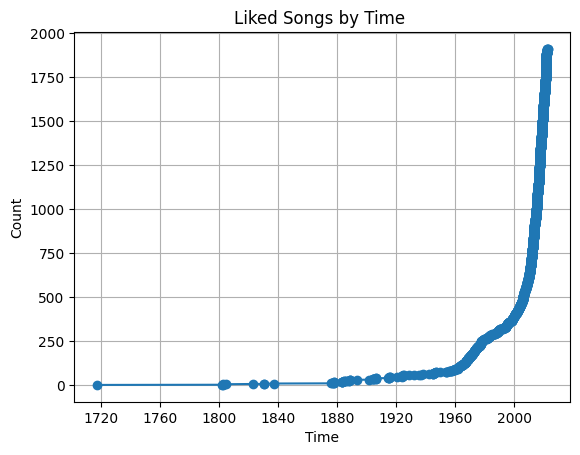

In [378]:
import matplotlib.pyplot as plt


plt.plot(date_index_df['Count'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Liked Songs by Time ')
plt.grid(True)
plt.show()

In [381]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [382]:
for_decomp = date_index_df['Count']

In [388]:
for_decomp.dtypes

dtype('int64')

<Figure size 640x480 with 0 Axes>

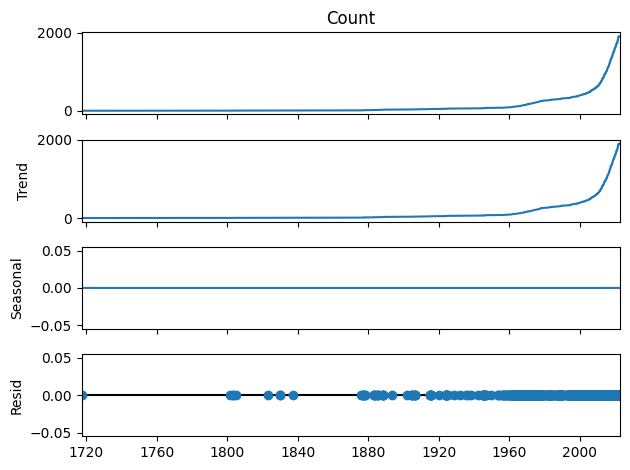

In [406]:
liked_decomp  = seasonal_decompose(for_decomp, period = 1 )
fig = plt.figure()
fig = liked_decomp.plot()

<Axes: xlabel='Release_Date'>

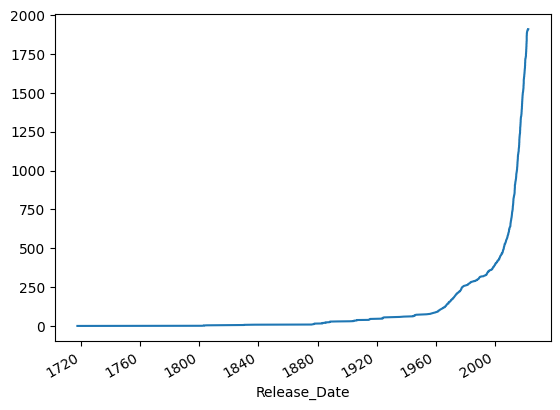

In [401]:
liked_decomp.trend.plot()

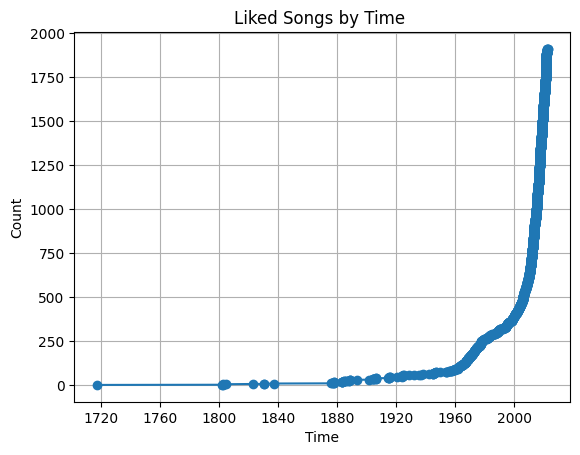

In [402]:

plt.plot(date_index_df['Count'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Liked Songs by Time ')
plt.grid(True)
plt.show()

As we can see as time goes on my playlist grew exponentially. There were some classical songs in there so there are some songs the pre date america. 

In conclusion I learned a few things about my listening habits and a lot about data collection using API's. We can see that I mostly listen to songs by artists born in america and songs that were released after 2000. I learned that using the OpenAi API was probably not the best way to collect information of the artist and songs that I like. The openai API generates text very well but the accuracy of the information it provides is not that reliable and caused a huge headache on my end. But, I do think that it got enough of the data correct that we can see the overall listening habits for the map and time of release. 

When I come back to this project I would love to add some functionality to the map by adding a slider to the map and be able to queue all the songs that fall under a single point on the map. The slider would let you see how your map is changing when you go through the years of the release date of your songs. I would also change the project to allow me to input any playlist I have on spotify and see the map for that playlist. It would be great if I could get it working well enought that you can look at your playlists too. 